# Neural Network using tensorflow
for this model whe used some information from "https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/"

In [1]:
# import libraries
import tensorflow.keras as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# load data
complete_df = pd.read_csv('data/AmesHousingPreprocessed.csv')
complete_df = complete_df.drop('Unnamed: 0', axis=1)
display(complete_df)

,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Year Remod/Add,Full Bath,Year Built,1st Flr SF,Total Bsmt SF,Garage Area,Garage Cars,Gr Liv Area,Overall Qual,SalePrice.1
0,0,0,0,0,1,0,0,0,0,0,...,-1.155886,-1.019607,-0.368243,1.281557,0.065626,0.258714,0.309465,0.313663,-0.061812,5.332438
1,0,0,0,1,0,0,0,0,0,0,...,-1.107938,-1.019607,-0.335146,-0.675537,-0.384244,1.197200,-1.003952,-1.192617,-0.771063,5.021189
2,0,0,0,0,1,0,0,0,0,0,...,-1.251781,-1.019607,-0.434438,0.439492,0.631372,-0.744814,-1.003952,-0.334434,-0.061812,5.235528
3,0,0,0,0,1,0,0,0,0,0,...,-0.772303,0.794069,-0.103465,2.450663,2.405858,0.230839,0.309465,1.213467,0.647439,5.387390
4,0,0,0,0,1,0,0,0,0,0,...,0.666134,0.794069,0.856357,-0.593133,-0.279728,0.045000,0.309465,0.260151,-0.771063,5.278525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2898,0,0,0,0,1,0,0,0,0,0,...,-0.005137,-1.019607,0.426092,-0.399998,-0.109323,0.537472,0.309465,-0.980548,-0.061812,5.153815
2899,0,0,0,0,1,0,0,0,0,0,...,-0.053085,-1.019607,0.392995,-0.660086,-0.425141,0.054292,0.309465,-1.180725,-0.771063,5.117271
2900,0,0,0,0,1,0,0,0,0,0,...,0.378446,-1.019607,0.690871,-0.484977,-0.316081,-2.194355,-2.317368,-1.045953,-0.771063,5.120574
2901,0,0,0,0,1,0,0,0,0,0,...,-0.436668,-1.019607,0.095119,0.593999,0.767696,-0.252342,0.309465,-0.215517,-0.771063,5.230449


In [3]:
# split data into input and target
target = complete_df['SalePrice']
input_df = complete_df.drop('SalePrice', axis=1)

display(input_df.head())

,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,...,Year Remod/Add,Full Bath,Year Built,1st Flr SF,Total Bsmt SF,Garage Area,Garage Cars,Gr Liv Area,Overall Qual,SalePrice.1
0,0,0,0,0,1,0,0,0,0,0,...,-1.155886,-1.019607,-0.368243,1.281557,0.065626,0.258714,0.309465,0.313663,-0.061812,5.332438
1,0,0,0,1,0,0,0,0,0,0,...,-1.107938,-1.019607,-0.335146,-0.675537,-0.384244,1.197200,-1.003952,-1.192617,-0.771063,5.021189
2,0,0,0,0,1,0,0,0,0,0,...,-1.251781,-1.019607,-0.434438,0.439492,0.631372,-0.744814,-1.003952,-0.334434,-0.061812,5.235528
3,0,0,0,0,1,0,0,0,0,0,...,-0.772303,0.794069,-0.103465,2.450663,2.405858,0.230839,0.309465,1.213467,0.647439,5.387390
4,0,0,0,0,1,0,0,0,0,0,...,0.666134,0.794069,0.856357,-0.593133,-0.279728,0.045000,0.309465,0.260151,-0.771063,5.278525


In [4]:
# convert the pandas dataframes to numpy ndarrays
X_np = input_df.to_numpy()
y_np = target.to_numpy()

# split the data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, train_size=0.7, random_state=1265599650)

# find number of features
n_features = input_df.shape[1]

In [5]:
def build_model(hp):
    m1 = tf.metrics.RootMeanSquaredError()
    m2 = 'mean_absolute_percentage_error'
    
    model = Sequential()
    model.add(Dense(
        hp.Choice('units', [8, 16, 32]),
        activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='Adam', loss=tf.metrics.mean_squared_error, metrics=[m1, m2])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [6]:
"""
Tihs piece of code is not used, but we experimented with it.
"""
# define metrics
# Root Mean Square Error function from Keras Metrics. 
# source: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError
m1 = tf.metrics.RootMeanSquaredError()
m2 = 'mean_absolute_percentage_error'

# create layers

# for the hidden layer we choose ReLu as our activation function since it is 
# less susceptible to vanishing gradients that prevent deep models from being trained
# for a regression model we use an output layer without any activation function 
# as we are interested in numerical values without any transformation
model = tf.Sequential()

# input layer
model.add(Dense(n_features, activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# hidden layer 1
model.add(Dense(int(0.66*n_features), activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# hidden layer 2
model.add(Dense(int(0.66*n_features), activation='relu'))
model.add(Dense(int(0.66*n_features), activation='relu'))
#model.add(Dropout(0.2))
#model.add(BatchNormalization())

# output layer
model.add(Dense(1, input_shape=(n_features,)))

# compile model
# use Adam as optimizer because of fast and accurate converging 
# source: https://medium.com/mdr-inc/from-sgd-to-adam-c9fce513c4bb 
model.compile(optimizer='Adam', loss=tf.metrics.mean_squared_error, metrics=[m1, m2])

In [7]:
# fit the model
# choose batch size of 32 after trying 32, 64 and 128
# source: https://datascience.stackexchange.com/questions/18414/are-there-any-rules-for-choosing-the-size-of-a-mini-batch
best_model.fit(X_train, y_train,
          batch_size=32, epochs=200,
          validation_data=(X_test, y_test))

Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.0128 - root_mean_squared_error: 0.1130 - mean_absolute_percentage_error: 1.6066 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0888 - val_mean_absolute_percentage_error: 1.2604
Epoch 2/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0053 - root_mean_squared_error: 0.0726 - mean_absolute_percentage_error: 1.0324 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0765 - val_mean_absolute_percentage_error: 1.0718
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0619 - mean_absolute_percentage_error: 0.8786 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691 - val_mean_absolute_percentage_error: 0.9622
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - mean_absolute_percentage_error: 0.7728 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654 - val_mean_absolu

64/64 [==============================] - 0s 2ms/step - loss: 5.0104e-04 - root_mean_squared_error: 0.0224 - mean_absolute_percentage_error: 0.3306 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337 - val_mean_absolute_percentage_error: 0.3984
Epoch 33/200
64/64 [==============================] - 0s 2ms/step - loss: 4.7025e-04 - root_mean_squared_error: 0.0217 - mean_absolute_percentage_error: 0.3192 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358 - val_mean_absolute_percentage_error: 0.4529
Epoch 34/200
64/64 [==============================] - 0s 1ms/step - loss: 4.6550e-04 - root_mean_squared_error: 0.0216 - mean_absolute_percentage_error: 0.3158 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353 - val_mean_absolute_percentage_error: 0.4373
Epoch 35/200
64/64 [==============================] - 0s 2ms/step - loss: 4.5460e-04 - root_mean_squared_error: 0.0213 - mean_absolute_percentage_error: 0.3131 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316 - val_mean

64/64 [==============================] - 0s 1ms/step - loss: 3.0942e-04 - root_mean_squared_error: 0.0176 - mean_absolute_percentage_error: 0.2594 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342 - val_mean_absolute_percentage_error: 0.4846
Epoch 64/200
64/64 [==============================] - 0s 2ms/step - loss: 4.1625e-04 - root_mean_squared_error: 0.0204 - mean_absolute_percentage_error: 0.3022 - val_loss: 6.7279e-04 - val_root_mean_squared_error: 0.0259 - val_mean_absolute_percentage_error: 0.3083
Epoch 65/200
64/64 [==============================] - 0s 2ms/step - loss: 4.5819e-04 - root_mean_squared_error: 0.0214 - mean_absolute_percentage_error: 0.3211 - val_loss: 6.8443e-04 - val_root_mean_squared_error: 0.0262 - val_mean_absolute_percentage_error: 0.3027
Epoch 66/200
64/64 [==============================] - 0s 2ms/step - loss: 2.5268e-04 - root_mean_squared_error: 0.0159 - mean_absolute_percentage_error: 0.2374 - val_loss: 6.1838e-04 - val_root_mean_squared_error: 0.024

Epoch 94/200
64/64 [==============================] - 0s 1ms/step - loss: 2.9380e-04 - root_mean_squared_error: 0.0171 - mean_absolute_percentage_error: 0.2576 - val_loss: 6.4784e-04 - val_root_mean_squared_error: 0.0255 - val_mean_absolute_percentage_error: 0.3350
Epoch 95/200
64/64 [==============================] - 0s 1ms/step - loss: 2.0543e-04 - root_mean_squared_error: 0.0143 - mean_absolute_percentage_error: 0.2143 - val_loss: 4.2554e-04 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_percentage_error: 0.2348
Epoch 96/200
64/64 [==============================] - 0s 1ms/step - loss: 1.7399e-04 - root_mean_squared_error: 0.0132 - mean_absolute_percentage_error: 0.1961 - val_loss: 6.1553e-04 - val_root_mean_squared_error: 0.0248 - val_mean_absolute_percentage_error: 0.3119
Epoch 97/200
64/64 [==============================] - 0s 1ms/step - loss: 1.8310e-04 - root_mean_squared_error: 0.0135 - mean_absolute_percentage_error: 0.1998 - val_loss: 4.5866e-04 - val_root_mean_squ

Epoch 125/200
64/64 [==============================] - 0s 1ms/step - loss: 1.4936e-04 - root_mean_squared_error: 0.0122 - mean_absolute_percentage_error: 0.1825 - val_loss: 4.2582e-04 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_percentage_error: 0.2141
Epoch 126/200
64/64 [==============================] - 0s 1ms/step - loss: 1.2366e-04 - root_mean_squared_error: 0.0111 - mean_absolute_percentage_error: 0.1651 - val_loss: 4.8249e-04 - val_root_mean_squared_error: 0.0220 - val_mean_absolute_percentage_error: 0.2733
Epoch 127/200
64/64 [==============================] - 0s 1ms/step - loss: 1.8846e-04 - root_mean_squared_error: 0.0137 - mean_absolute_percentage_error: 0.2044 - val_loss: 4.8078e-04 - val_root_mean_squared_error: 0.0219 - val_mean_absolute_percentage_error: 0.2697
Epoch 128/200
64/64 [==============================] - 0s 1ms/step - loss: 1.4326e-04 - root_mean_squared_error: 0.0120 - mean_absolute_percentage_error: 0.1752 - val_loss: 3.8681e-04 - val_root_mean

Epoch 156/200
64/64 [==============================] - 0s 2ms/step - loss: 1.4995e-04 - root_mean_squared_error: 0.0122 - mean_absolute_percentage_error: 0.1838 - val_loss: 2.4328e-04 - val_root_mean_squared_error: 0.0156 - val_mean_absolute_percentage_error: 0.1629
Epoch 157/200
64/64 [==============================] - 0s 1ms/step - loss: 1.1471e-04 - root_mean_squared_error: 0.0107 - mean_absolute_percentage_error: 0.1594 - val_loss: 4.2660e-04 - val_root_mean_squared_error: 0.0207 - val_mean_absolute_percentage_error: 0.2460
Epoch 158/200
64/64 [==============================] - 0s 2ms/step - loss: 1.6359e-04 - root_mean_squared_error: 0.0128 - mean_absolute_percentage_error: 0.1914 - val_loss: 4.7155e-04 - val_root_mean_squared_error: 0.0217 - val_mean_absolute_percentage_error: 0.2606
Epoch 159/200
64/64 [==============================] - 0s 2ms/step - loss: 1.2036e-04 - root_mean_squared_error: 0.0110 - mean_absolute_percentage_error: 0.1625 - val_loss: 2.3293e-04 - val_root_mean

Epoch 187/200
64/64 [==============================] - 0s 2ms/step - loss: 6.6621e-04 - root_mean_squared_error: 0.0258 - mean_absolute_percentage_error: 0.3743 - val_loss: 3.1357e-04 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_percentage_error: 0.1823
Epoch 188/200
64/64 [==============================] - 0s 2ms/step - loss: 3.2336e-04 - root_mean_squared_error: 0.0180 - mean_absolute_percentage_error: 0.2657 - val_loss: 2.2985e-04 - val_root_mean_squared_error: 0.0152 - val_mean_absolute_percentage_error: 0.1866
Epoch 189/200
64/64 [==============================] - 0s 2ms/step - loss: 7.9020e-05 - root_mean_squared_error: 0.0089 - mean_absolute_percentage_error: 0.1291 - val_loss: 2.4772e-04 - val_root_mean_squared_error: 0.0157 - val_mean_absolute_percentage_error: 0.1472
Epoch 190/200
64/64 [==============================] - 0s 2ms/step - loss: 6.3442e-05 - root_mean_squared_error: 0.0080 - mean_absolute_percentage_error: 0.1179 - val_loss: 2.1702e-04 - val_root_mean

In [8]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                2720      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,753
Trainable params: 2,753
Non-trainable params: 0
_________________________________________________________________


(0.0, 0.02)

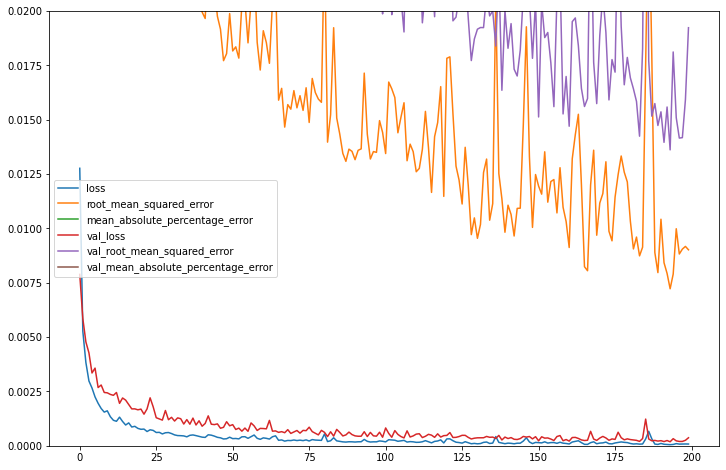

In [9]:
loss_df = pd.DataFrame(best_model.history.history)
#display(loss_df)
loss_df.plot(figsize=(12,8))
plt.ylim((0,0.02))

In [10]:
from sklearn import metrics

y_pred = best_model.predict(X_test)
# accuracy 
print('Variance score:',metrics.explained_variance_score(y_test,y_pred))

Variance score: 0.9907894825498924


### Model 2

In [11]:
#### verbeterpunten:
# validation data gebruiken                           
# k folds
# andere metrics voor aflezen                     check
# adam vs andere andere sgd methods testen        check, Adam ziet er het best uit
# hidden layers toevoegen 
# dropout layers toevoegen                        dropout layers hebben geen positief effect op het model
# aantal nodes per layer aanpassen
# batchsize aanpassen (32, 64 of 128)             check, 32 lijkt het beste te werken
# aantal epochs                                   check, na 20 epochs lijkt het model het meest te leren, daarna improved het niet heel veel meer                                     
# onze loss plotten                               check
